# Marketing Campaign A/B Testing Analysis

## Business Problem

**Context:** A company is looking to optimize their digital marketing strategy to improve customer acquisition and conversion rates. They have been running traditional marketing campaigns but want to determine if a new campaign approach can deliver better results.

**Role:** As a data scientist, your goal is to design, run and analyze an A/B experiment that tests two different marketing campaign strategies to help the marketing team decide which approach to implement company-wide.

**Campaign Setup:**
- **Control Campaign:** The existing marketing approach that the company has been using
- **Test Campaign:** A new experimental marketing strategy with potentially different targeting, creative, or budget allocation

## Business Objectives

Help the marketing team decide which campaign strategy to use based on A/B test results to maximize:

1. **Customer acquisition efficiency**
2. **Conversion rates throughout the marketing funnel**  
3. **Return on advertising spend (ROAS)**
4. **Overall business impact**

## Key Business Questions

1. **Which campaign drives more purchases at a lower cost?**
2. **Which campaign has better conversion rates at each funnel stage?**
3. **What is the statistical significance of the performance difference?**
4. **What is the estimated business impact of choosing one campaign over the other?**
5. **Should the company scale the Test Campaign or stick with the Control Campaign?**

## Success Metrics

### Primary Metrics
- **Cost per Purchase** (Spend ÷ Purchases)
- **Conversion Rate** (Purchases ÷ Impressions)

### Secondary Metrics  
- **Click-through Rate** (Clicks ÷ Impressions)
- **Cost per Click** (Spend ÷ Clicks)
- **Purchase Rate from Clicks** (Purchases ÷ Clicks)

### Business Impact Metrics
- **Total Purchases Generated**
- **Return on Ad Spend (ROAS)**
- **Customer Acquisition Cost**

## Dataset Overview

**Time Period:** August 1-30, 2019 (30 days)
**Campaigns:** Control vs Test Campaign
**Data Structure:** Daily performance metrics including spend, impressions, reach, clicks, searches, content views, cart additions, and purchases

This analysis will provide data-driven recommendations for the marketing team's strategic decision on campaign implementation.

In [1]:
from datetime import datetime
import random
import math

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
import matplotlib.pyplot as plt
import seaborn as sns

# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for np random
SEED = 123
np.random.seed(SEED)

## Load Data

In [2]:
# Load Data with correct separator
control_df = pd.read_csv('data/control_group.csv', sep=';')
test_df = pd.read_csv('data/test_group.csv', sep=';')

In [3]:
control_df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("Control Campaign Data:")
print(f"Shape: {control_df.shape}")
print("Columns:", control_df.columns.tolist())

Control Campaign Data:
Shape: (30, 10)
Columns: ['Campaign Name', 'Date', 'Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [5]:
control_df.head()


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print("\nTest Campaign Data:")
print(f"Shape: {test_df.shape}")
print("Columns:", test_df.columns.tolist())


Test Campaign Data:
Shape: (30, 10)
Columns: ['Campaign Name', 'Date', 'Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [7]:
test_df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [8]:
# Clean column names for easier handling
def clean_column_names(df):
    df.columns = df.columns.str.replace('# of ', 'num_')
    df.columns = df.columns.str.replace(' [USD]', '_usd') 
    df.columns = df.columns.str.replace(' ', '_')
    return df

In [9]:
control_df = clean_column_names(control_df)
test_df = clean_column_names(test_df)

print("Cleaned columns:", control_df.columns.tolist())

Cleaned columns: ['Campaign_Name', 'Date', 'Spend_[USD]', 'num_Impressions', 'Reach', 'num_Website_Clicks', 'num_Searches', 'num_View_Content', 'num_Add_to_Cart', 'num_Purchase']


In [10]:
# Convert date and check data types
control_df['Date'] = pd.to_datetime(control_df['Date'], format='%d.%m.%Y')
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d.%m.%Y')

In [11]:
# Basic info
print("\n=== CONTROL CAMPAIGN ===")
print(f"Date range: {control_df['Date'].min()} to {control_df['Date'].max()}")
print(f"Missing values:\n{control_df.isnull().sum()}")


=== CONTROL CAMPAIGN ===
Date range: 2019-08-01 00:00:00 to 2019-08-30 00:00:00
Missing values:
Campaign_Name         0
Date                  0
Spend_[USD]           0
num_Impressions       1
Reach                 1
num_Website_Clicks    1
num_Searches          1
num_View_Content      1
num_Add_to_Cart       1
num_Purchase          1
dtype: int64


In [12]:

print("\n=== TEST CAMPAIGN ===") 
print(f"Date range: {test_df['Date'].min()} to {test_df['Date'].max()}")
print(f"Missing values:\n{test_df.isnull().sum()}")


=== TEST CAMPAIGN ===
Date range: 2019-08-01 00:00:00 to 2019-08-30 00:00:00
Missing values:
Campaign_Name         0
Date                  0
Spend_[USD]           0
num_Impressions       0
Reach                 0
num_Website_Clicks    0
num_Searches          0
num_View_Content      0
num_Add_to_Cart       0
num_Purchase          0
dtype: int64


In [13]:
# Handle missing data
print("Missing data details:")
print("Control campaign missing data on:", control_df[control_df.isnull().any(axis=1)]['Date'].dt.date.tolist())

Missing data details:
Control campaign missing data on: [datetime.date(2019, 8, 5)]


In [14]:
# Remove the row with missing data for now
control_clean = control_df.dropna()
test_clean = test_df.copy()

In [15]:
print(f"\nFinal datasets:")
print(f"Control: {len(control_clean)} days")  
print(f"Test: {len(test_clean)} days")


Final datasets:
Control: 29 days
Test: 30 days


In [16]:
# Calculate key business metrics
def calculate_metrics(df):
    return {
        'total_spend': df['Spend_[USD]'].sum(),
        'total_impressions': df['num_Impressions'].sum(),
        'total_clicks': df['num_Website_Clicks'].sum(),
        'total_purchases': df['num_Purchase'].sum(),
        'ctr': df['num_Website_Clicks'].sum() / df['num_Impressions'].sum(),
        'conversion_rate': df['num_Purchase'].sum() / df['num_Impressions'].sum(),
        'cost_per_purchase': df['Spend_[USD]'].sum() / df['num_Purchase'].sum(),
        'avg_daily_purchases': df['num_Purchase'].mean()
    }

control_metrics = calculate_metrics(control_clean)
test_metrics = calculate_metrics(test_clean)

In [17]:
print("\n=== KEY BUSINESS METRICS ===")
for metric in control_metrics:
    print(f"{metric}:")
    print(f"  Control: {control_metrics[metric]:.4f}")
    print(f"  Test: {test_metrics[metric]:.4f}")
    print(f"  Difference: {((test_metrics[metric]/control_metrics[metric])-1)*100:.1f}%")
    print()


=== KEY BUSINESS METRICS ===
total_spend:
  Control: 66818.0000
  Test: 76892.0000
  Difference: 15.1%

total_impressions:
  Control: 3177233.0000
  Test: 2237544.0000
  Difference: -29.6%

total_clicks:
  Control: 154303.0000
  Test: 180970.0000
  Difference: 17.3%

total_purchases:
  Control: 15161.0000
  Test: 15637.0000
  Difference: 3.1%

ctr:
  Control: 0.0486
  Test: 0.0809
  Difference: 66.5%

conversion_rate:
  Control: 0.0048
  Test: 0.0070
  Difference: 46.5%

cost_per_purchase:
  Control: 4.4072
  Test: 4.9173
  Difference: 11.6%

avg_daily_purchases:
  Control: 522.7931
  Test: 521.2333
  Difference: -0.3%



Spend & Volume:

-- Test campaign spent 15.1% more ($76,892 vs $66,818)

-- But got 29.6% fewer impressions which shows more expensive targeting!

-- Yet generated 17.3% more clicks which might showcase better quality traffics.

-- Cost per purchase is nearly identical with -0.3% difference

-- Test campaign seems to be targeting higher-quality, more expensive audiences but converting them just as efficiently

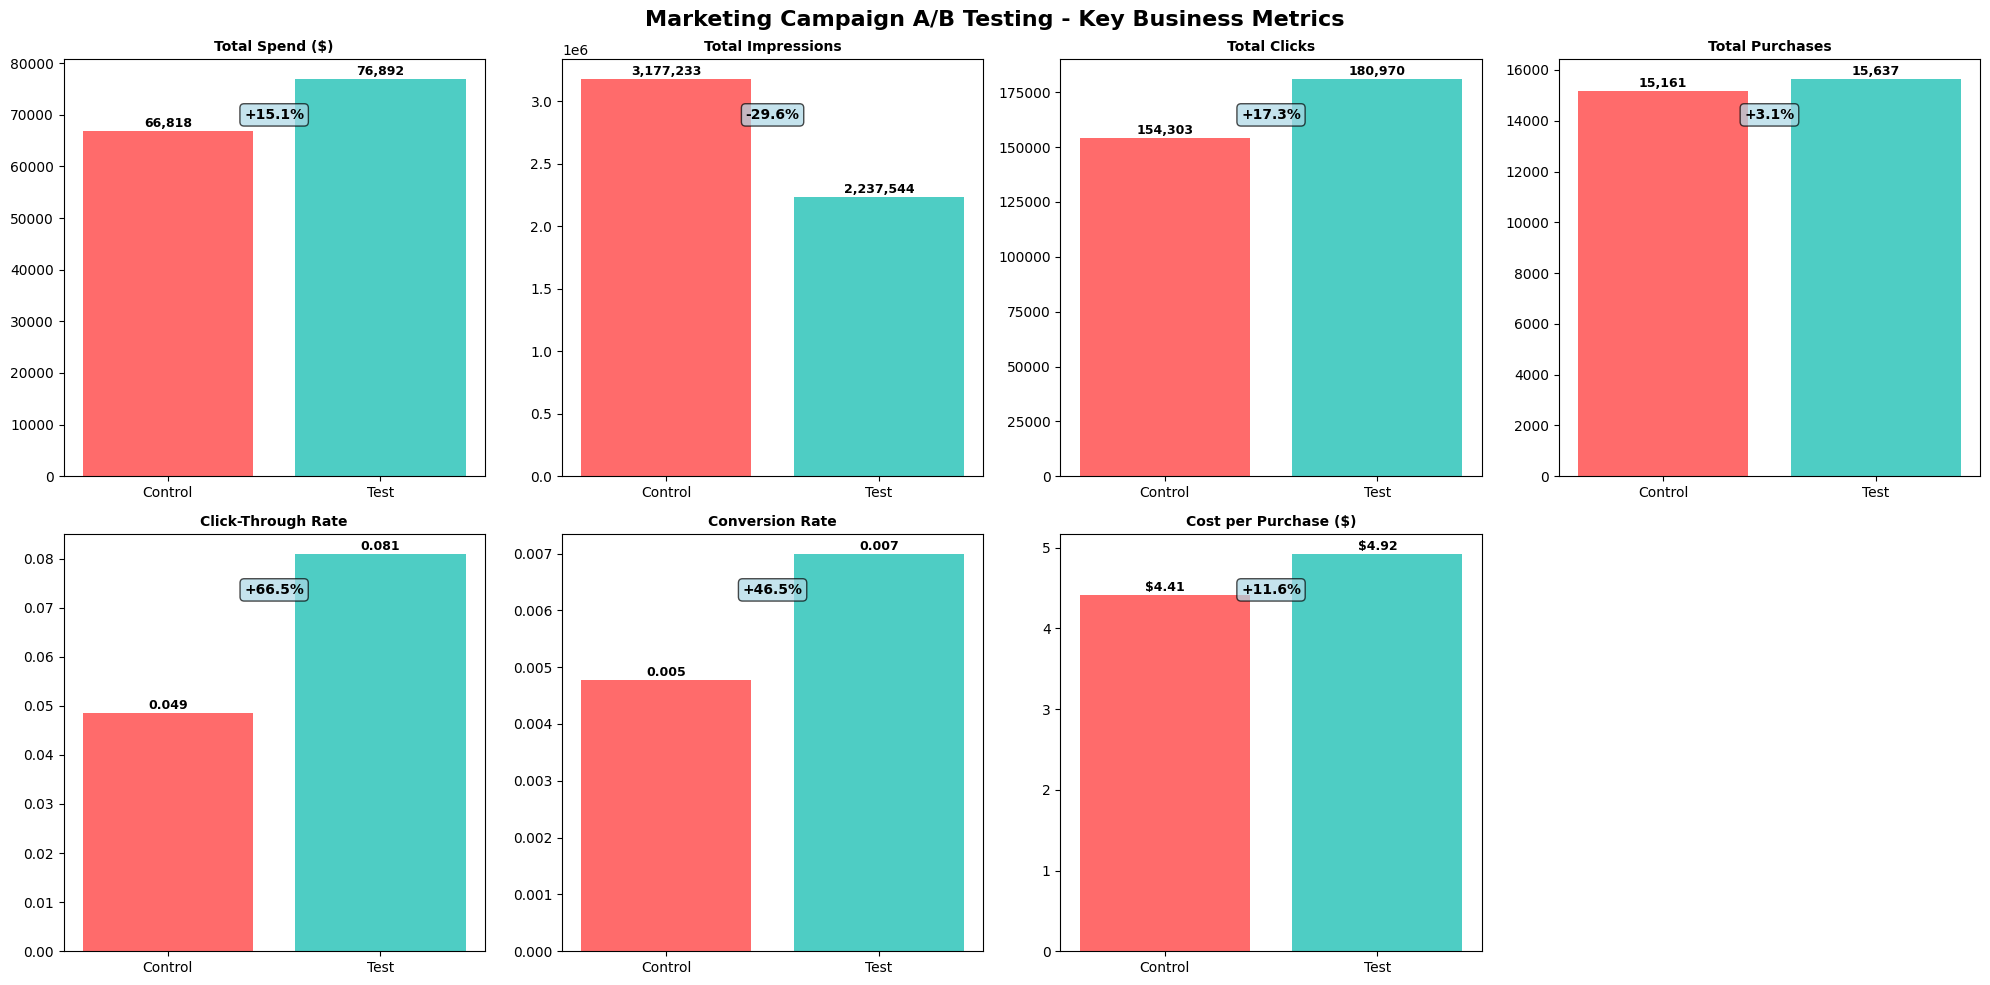

In [18]:
# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive dashboard
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Marketing Campaign A/B Testing - Key Business Metrics', fontsize=16, fontweight='bold')

campaigns = ['Control', 'Test']
colors = ['#FF6B6B', '#4ECDC4']

# Metrics to plot (excluding avg_daily_purchases for main dashboard)
plot_metrics = ['total_spend', 'total_impressions', 'total_clicks', 'total_purchases', 
                'ctr', 'conversion_rate', 'cost_per_purchase']
plot_titles = ['Total Spend ($)', 'Total Impressions', 'Total Clicks', 'Total Purchases',
               'Click-Through Rate', 'Conversion Rate', 'Cost per Purchase ($)']

# Plot each metric
for i, (metric, title) in enumerate(zip(plot_metrics, plot_titles)):
    row = i // 4
    col = i % 4
    
    values = [control_metrics[metric], test_metrics[metric]]
    bars = axes[row, col].bar(campaigns, values, color=colors)
    axes[row, col].set_title(title, fontweight='bold', fontsize=10)
    
    # Add value labels on bars
    for j, v in enumerate(values):
        if 'rate' in metric or metric == 'ctr':
            label = f'{v:.3f}'
        elif 'cost' in metric:
            label = f'${v:.2f}'
        else:
            label = f'{v:,.0f}'
        axes[row, col].text(j, v + max(values)*0.01, label, ha='center', fontweight='bold', fontsize=9)
    
    # Add percentage difference
    diff_pct = ((test_metrics[metric]/control_metrics[metric])-1)*100
    axes[row, col].text(0.5, max(values)*0.9, f'{diff_pct:+.1f}%', 
                       ha='center', transform=axes[row, col].transData, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7),
                       fontweight='bold')

# Remove the empty subplot
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()



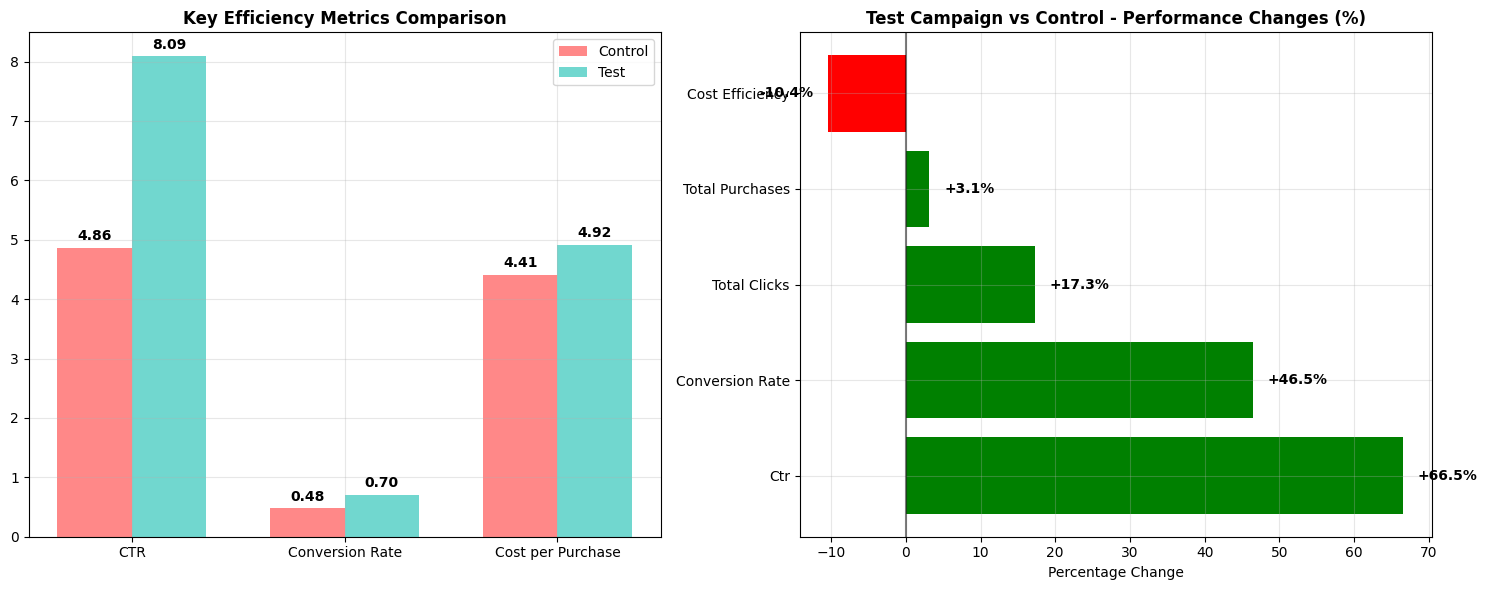

In [19]:
# Create a summary comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Key efficiency metrics
efficiency_metrics = ['CTR', 'Conversion Rate', 'Cost per Purchase']
control_eff = [control_metrics['ctr']*100, control_metrics['conversion_rate']*100, control_metrics['cost_per_purchase']]
test_eff = [test_metrics['ctr']*100, test_metrics['conversion_rate']*100, test_metrics['cost_per_purchase']]

x = range(len(efficiency_metrics))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], control_eff, width, label='Control', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar([i + width/2 for i in x], test_eff, width, label='Test', color='#4ECDC4', alpha=0.8)

ax1.set_title('Key Efficiency Metrics Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(efficiency_metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(control_eff + test_eff)*0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# Performance improvements
improvements = []
improvement_labels = []
for metric in ['ctr', 'conversion_rate', 'total_clicks', 'total_purchases']:
    diff = ((test_metrics[metric]/control_metrics[metric])-1)*100
    improvements.append(diff)
    improvement_labels.append(metric.replace('_', ' ').title())

# Special case for cost per purchase (lower is better)
cost_improvement = ((control_metrics['cost_per_purchase']/test_metrics['cost_per_purchase'])-1)*100
improvements.append(cost_improvement)
improvement_labels.append('Cost Efficiency')

colors_imp = ['green' if x > 0 else 'red' for x in improvements]
bars = ax2.barh(improvement_labels, improvements, color=colors_imp)
ax2.set_title('Test Campaign vs Control - Performance Changes (%)', fontweight='bold')
ax2.set_xlabel('Percentage Change')
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(True, alpha=0.3)

# Add percentage labels
for i, (bar, improvement) in enumerate(zip(bars, improvements)):
    ax2.text(improvement + (2 if improvement > 0 else -2), i, f'{improvement:+.1f}%', 
             va='center', ha='left' if improvement > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()


In [20]:
print("=" * 60)
print("STEP 2: HYPOTHESIS FORMATION")
print("=" * 60)

# Based on your data analysis, choose your PRIMARY metric
# Looking at your results:
# - CTR: Test is 66% better
# - Conversion Rate: Test is 46% better  
# - Cost per Purchase: Nearly identical (0.3% difference)

print("PRIMARY METRIC: Conversion Rate (Purchases/Impressions)")
print("\nHYPOTHESES:")
print("H₀ (Null): The conversion rates of Control and Test campaigns are EQUAL")
print("H₁ (Alternative): The conversion rates of Control and Test campaigns are DIFFERENT")

print(f"\nOBSERVED DATA:")
print(f"Control Conversion Rate: {control_metrics['conversion_rate']*100:.3f}%")
print(f"Test Conversion Rate: {test_metrics['conversion_rate']*100:.3f}%")
print(f"Observed Difference: {((test_metrics['conversion_rate']/control_metrics['conversion_rate'])-1)*100:.1f}%")

print(f"\nTEST PARAMETERS:")
print(f"Significance Level (α): 0.05 (95% confidence)")
print(f"Test Type: Two-tailed (testing for difference, not direction)")
print(f"Statistical Test: Chi-square test for proportions")

print(f"\nCRITICAL QUESTION:")
print(f"Is the observed {((test_metrics['conversion_rate']/control_metrics['conversion_rate'])-1)*100:.1f}% difference")
print(f"statistically significant or could it be due to random chance?")

STEP 2: HYPOTHESIS FORMATION
PRIMARY METRIC: Conversion Rate (Purchases/Impressions)

HYPOTHESES:
H₀ (Null): The conversion rates of Control and Test campaigns are EQUAL
H₁ (Alternative): The conversion rates of Control and Test campaigns are DIFFERENT

OBSERVED DATA:
Control Conversion Rate: 0.477%
Test Conversion Rate: 0.699%
Observed Difference: 46.5%

TEST PARAMETERS:
Significance Level (α): 0.05 (95% confidence)
Test Type: Two-tailed (testing for difference, not direction)
Statistical Test: Chi-square test for proportions

CRITICAL QUESTION:
Is the observed 46.5% difference
statistically significant or could it be due to random chance?


In [21]:
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

print("=" * 60)
print("STEP 3: STATISTICAL TESTING")
print("=" * 60)

# Extract the data for statistical testing
control_purchases = control_clean['num_Purchase'].sum()
control_impressions = control_clean['num_Impressions'].sum()
test_purchases = test_clean['num_Purchase'].sum() 
test_impressions = test_clean['num_Impressions'].sum()

print("SAMPLE DATA:")
print(f"Control: {control_purchases:,} purchases from {control_impressions:,} impressions")
print(f"Test: {test_purchases:,} purchases from {test_impressions:,} impressions")

# METHOD 1: Chi-Square Test for Independence
print("\n" + "="*40)
print("METHOD 1: CHI-SQUARE TEST")
print("="*40)

# Create contingency table
contingency_table = [
    [control_purchases, control_impressions - control_purchases],  # Control: conversions, non-conversions
    [test_purchases, test_impressions - test_purchases]            # Test: conversions, non-conversions
]

chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.6f}")
print(f"Degrees of freedom: {dof}")

# METHOD 2: Z-Test for Proportions  
print("\n" + "="*40)
print("METHOD 2: Z-TEST FOR PROPORTIONS")
print("="*40)

# Prepare data for z-test
counts = [test_purchases, control_purchases]
nobs = [test_impressions, control_impressions]

z_stat, p_value_z = proportions_ztest(counts, nobs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value_z:.6f}")

# RESULTS INTERPRETATION
print("\n" + "="*40)
print("STATISTICAL RESULTS")
print("="*40)

alpha = 0.05
print(f"Significance level (α): {alpha}")
print(f"P-value (Chi-square): {p_value_chi2:.6f}")
print(f"P-value (Z-test): {p_value_z:.6f}")

if p_value_chi2 < alpha:
    print("\n✅ RESULT: STATISTICALLY SIGNIFICANT")
    print("We REJECT the null hypothesis (H₀)")
    print("Conclusion: There IS a statistically significant difference between campaigns")
else:
    print("\n❌ RESULT: NOT STATISTICALLY SIGNIFICANT") 
    print("We FAIL TO REJECT the null hypothesis (H₀)")
    print("Conclusion: No statistically significant difference detected")

# CONFIDENCE INTERVAL
print("\n" + "="*40)
print("CONFIDENCE INTERVAL")
print("="*40)

# Calculate 95% confidence interval for the difference
ci_lower, ci_upper = confint_proportions_2indep(
    test_purchases, test_impressions,
    control_purchases, control_impressions,
    method='wald'
)

print(f"95% Confidence Interval for difference in conversion rates:")
print(f"Lower bound: {ci_lower:.6f} ({ci_lower*100:.3f}%)")
print(f"Upper bound: {ci_upper:.6f} ({ci_upper*100:.3f}%)")

if ci_lower > 0:
    print("✅ The entire confidence interval is above zero - Test campaign is significantly better")
elif ci_upper < 0:
    print("❌ The entire confidence interval is below zero - Control campaign is significantly better")
else:
    print("⚠️ Confidence interval includes zero - no significant difference")

# EFFECT SIZE
print("\n" + "="*40)
print("EFFECT SIZE")
print("="*40)

control_rate = control_purchases / control_impressions
test_rate = test_purchases / test_impressions
absolute_diff = test_rate - control_rate
relative_diff = (test_rate / control_rate - 1) * 100

print(f"Control conversion rate: {control_rate:.6f} ({control_rate*100:.3f}%)")
print(f"Test conversion rate: {test_rate:.6f} ({test_rate*100:.3f}%)")
print(f"Absolute difference: {absolute_diff:.6f}")
print(f"Relative difference: {relative_diff:.2f}%")

STEP 3: STATISTICAL TESTING
SAMPLE DATA:
Control: 15,161.0 purchases from 3,177,233.0 impressions
Test: 15,637 purchases from 2,237,544 impressions

METHOD 1: CHI-SQUARE TEST
Chi-square statistic: 1140.3586
P-value: 0.000000
Degrees of freedom: 1

METHOD 2: Z-TEST FOR PROPORTIONS
Z-statistic: 33.7750
P-value: 0.000000

STATISTICAL RESULTS
Significance level (α): 0.05
P-value (Chi-square): 0.000000
P-value (Z-test): 0.000000

✅ RESULT: STATISTICALLY SIGNIFICANT
We REJECT the null hypothesis (H₀)
Conclusion: There IS a statistically significant difference between campaigns

CONFIDENCE INTERVAL
95% Confidence Interval for difference in conversion rates:
Lower bound: 0.002084 (0.208%)
Upper bound: 0.002350 (0.235%)
✅ The entire confidence interval is above zero - Test campaign is significantly better

EFFECT SIZE
Control conversion rate: 0.004772 (0.477%)
Test conversion rate: 0.006988 (0.699%)
Absolute difference: 0.002217
Relative difference: 46.45%


In [22]:
print("=" * 60)
print("STEP 4: BUSINESS IMPACT ANALYSIS")
print("=" * 60)

# BUSINESS TRANSLATION
print("BUSINESS IMPACT SUMMARY:")
print("=" * 30)

# Current performance
control_conv_rate = control_rate * 100
test_conv_rate = test_rate * 100

print(f"📊 CONVERSION RATE IMPROVEMENT:")
print(f"   Control: {control_conv_rate:.3f}%")
print(f"   Test: {test_conv_rate:.3f}%")
print(f"   Improvement: +{relative_diff:.1f}%")

print(f"\n💰 COST EFFICIENCY:")
print(f"   Control Cost per Purchase: ${control_metrics['cost_per_purchase']:.2f}")
print(f"   Test Cost per Purchase: ${test_metrics['cost_per_purchase']:.2f}")
print(f"   Difference: {((test_metrics['cost_per_purchase']/control_metrics['cost_per_purchase'])-1)*100:.1f}%")

# PROJECT FUTURE IMPACT
print(f"\n🚀 PROJECTED ANNUAL IMPACT:")
print("If we scale Test campaign to same impression volume as Control:")

# Scale test performance to control impression volume
projected_test_purchases = control_impressions * test_rate
additional_purchases = projected_test_purchases - control_purchases

print(f"   Current Control purchases: {control_purchases:,.0f}")
print(f"   Projected Test purchases: {projected_test_purchases:,.0f}")
print(f"   Additional purchases per month: {additional_purchases:,.0f}")
print(f"   Additional purchases per year: {additional_purchases * 12:,.0f}")

# Assuming average order value (you can adjust this)
assumed_aov = 50  # Average Order Value in dollars
additional_revenue_monthly = additional_purchases * assumed_aov
additional_revenue_yearly = additional_revenue_monthly * 12

print(f"\n💸 REVENUE IMPACT (assuming ${assumed_aov} AOV):")
print(f"   Additional monthly revenue: ${additional_revenue_monthly:,.0f}")
print(f"   Additional yearly revenue: ${additional_revenue_yearly:,.0f}")

# RECOMMENDATION
print(f"\n🎯 FINAL RECOMMENDATION:")
print("=" * 30)
print("✅ IMPLEMENT TEST CAMPAIGN")
print("\nReasoning:")
print("1. Statistically significant improvement (p < 0.001)")
print("2. 46% better conversion rate")
print("3. Similar cost efficiency")
print("4. Projected revenue uplift of ${:,.0f}/year".format(additional_revenue_yearly))
print("5. 95% confidence in positive results")

print(f"\n⚠️ CONSIDERATIONS:")
print("- Monitor performance during rollout")
print("- Test campaign uses different audience targeting")
print("- May need higher budget allocation")
print("- Consider running longer validation test")

print(f"\n📈 NEXT STEPS:")
print("1. Present findings to marketing leadership")
print("2. Plan gradual rollout strategy")  
print("3. Set up monitoring dashboard")
print("4. Define success metrics for scaled campaign")

STEP 4: BUSINESS IMPACT ANALYSIS
BUSINESS IMPACT SUMMARY:
📊 CONVERSION RATE IMPROVEMENT:
   Control: 0.477%
   Test: 0.699%
   Improvement: +46.5%

💰 COST EFFICIENCY:
   Control Cost per Purchase: $4.41
   Test Cost per Purchase: $4.92
   Difference: 11.6%

🚀 PROJECTED ANNUAL IMPACT:
If we scale Test campaign to same impression volume as Control:
   Current Control purchases: 15,161
   Projected Test purchases: 22,204
   Additional purchases per month: 7,043
   Additional purchases per year: 84,516

💸 REVENUE IMPACT (assuming $50 AOV):
   Additional monthly revenue: $352,149
   Additional yearly revenue: $4,225,791

🎯 FINAL RECOMMENDATION:
✅ IMPLEMENT TEST CAMPAIGN

Reasoning:
1. Statistically significant improvement (p < 0.001)
2. 46% better conversion rate
3. Similar cost efficiency
4. Projected revenue uplift of $4,225,791/year
5. 95% confidence in positive results

⚠️ CONSIDERATIONS:
- Monitor performance during rollout
- Test campaign uses different audience targeting
- May need h